In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AutoMLOps - Forecasting retail demand with Vertex AI and BigQuery ML 

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/automlops/blob/main/examples/training/04_bqml_forecasting-retail-demand.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/automlops/blob/main/examples/training/04_bqml_forecasting-retail-demand.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/automlops/main/examples/training/04_bqml_forecasting-retail-demand.ipynb">
        <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

# Overview

This tutorial explores using AutoMLOps for demand forecasting using a BigQuery public retail dataset. Being able to measure and forecast customer demand can help retailers better understand their customers, stock shelves with the right products, offer targeted promotions, and generally, better plan and manage their budgets. This notebook applies an ARIMA (Autoregressive integrated moving average) model from BigQuery ML on retail data. This notebook demonstrates how to train and evaluate a BigQuery ML model for demand forecasting datasets and extract actionable future insights.

#### ARIMA Modeling with BigQuery ML 

The <a href='https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average'>ARIMA model</a> is designed to analyze historical data, spot patterns over time, and project them into the future--in other words, forecasting. The model is available inside BigQuery ML and enables users to create and execute machine learning models directly in BigQuery using SQL queries. Working with BigQuery ML is advantageous, as it already has access to the data, it can handle most of the modeling details automatically if desired, and will store both the model and any predictions also inside BigQuery. 

### This tutorial is broken into 2 parts

[Part 1 : Data science exploration](#data_science_exploration)

[Part 2 : Automating pipeline creationg with AutoMLOps](#automlops)

# Objective

In this tutorial, you learn how to build ARIMA (Autoregressive integrated moving average) model from BigQuery ML on retail data. You will then learn how to create and run MLOps pipelines integrated with CI/CD. The pipeline goes through the following steps:

1. prepare_sales_table: Custom component that prepares the sales table.
2. create_training_dataset: Custom component that creates training data, ranging from today to N year(s) ago.
3. train_model: Train an ARIMA model on the training dataset.
4. evaluate_model: Evaluate the trained ARIMA model.
5. forecast: Custom component that runs a forecast for a given horizon period.

# Prerequisites

In order to use AutoMLOps, the following are required:

- Python 3.7 - 3.10
- [Google Cloud SDK 407.0.0](https://cloud.google.com/sdk/gcloud/reference)
- [beta 2022.10.21](https://cloud.google.com/sdk/gcloud/reference/beta)
- `git` installed
- `git` logged-in:
```
  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"
```
- [Application Default Credentials (ADC)](https://cloud.google.com/docs/authentication/provide-credentials-adc) are setup. This can be done through the following commands:
```
gcloud auth application-default login
gcloud config set account <account@example.com>
```

# APIs & IAM
Based on the user options selection, AutoMLOps will enable up to the following APIs during the provision step:
- [aiplatform.googleapis.com](https://cloud.google.com/vertex-ai/docs/reference/rest)
- [artifactregistry.googleapis.com](https://cloud.google.com/artifact-registry/docs/reference/rest)
- [cloudbuild.googleapis.com](https://cloud.google.com/build/docs/api/reference/rest)
- [cloudfunctions.googleapis.com](https://cloud.google.com/functions/docs/reference/rest)
- [cloudresourcemanager.googleapis.com](https://cloud.google.com/resource-manager/reference/rest)
- [cloudscheduler.googleapis.com](https://cloud.google.com/scheduler/docs/reference/rest)
- [cloudtasks.googleapis.com](https://cloud.google.com/tasks/docs/reference/rest)
- [compute.googleapis.com](https://cloud.google.com/compute/docs/reference/rest/v1)
- [iam.googleapis.com](https://cloud.google.com/iam/docs/reference/rest)
- [iamcredentials.googleapis.com](https://cloud.google.com/iam/docs/reference/credentials/rest)
- [ml.googleapis.com](https://cloud.google.com/ai-platform/training/docs/reference/rest)
- [pubsub.googleapis.com](https://cloud.google.com/pubsub/docs/reference/rest)
- [run.googleapis.com](https://cloud.google.com/run/docs/reference/rest)
- [storage.googleapis.com](https://cloud.google.com/storage/docs/apis)
- [sourcerepo.googleapis.com](https://cloud.google.com/source-repositories/docs/reference/rest)


AutoMLOps will create the following service account and update [IAM permissions](https://cloud.google.com/iam/docs/understanding-roles) during the provision step:
1. Pipeline Runner Service Account (defaults to: vertex-pipelines@PROJECT_ID.iam.gserviceaccount.com). Roles added:
- roles/aiplatform.serviceAgent

# User Guide

For a user-guide, please view these [slides](../../AutoMLOps_User_Guide.pdf).

# Costs

This tutorial uses billable components of Google Cloud:
- Vertex AI
- Artifact Registry
- Cloud Storage
- Cloud Source Repository
- Cloud Build
- Cloud Run
- Cloud Scheduler
- Cloud Pub/Sub

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

# Ground-rules for using AutoMLOps
1. Do not use variables, functions, code, etc. not defined within the scope of a custom component. These custom components will become containers and will have no reference to the out of scope code.
2. Import statements and helper functions must be added inside the function. Provide parameter type hints.
3. Test each of your components for accuracy and correctness before running them using AutoMLOps. We cannot fix bugs automatically; bugs are much more difficult to fix once they are made into pipelines.
4. If you are using Kubeflow, be sure to define all the requirements needed to run the custom component - it can be easy to leave out packages which will cause the container to fail when running within a pipeline. 


## Dataset

This notebook uses the BigQuery public retail data set from [BigQuery public datasets](https://cloud.google.com/bigquery/public-data).
The data covers 10 US stores and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price and gross margin.

## Setup Git
Set up your git configuration below

In [ ]:
!git config --global user.email 'you@example.com'
!git config --global user.name 'Your Name'

## Install AutoMLOps

Install AutoMLOps from [PyPI](https://pypi.org/project/google-cloud-automlops/), or locally by cloning the repo and running `pip install .`

In [ ]:
!pip3 install google-cloud-automlops --user

## Restart the kernel
Once you've installed the AutoMLOps package, you need to restart the notebook kernel so it can find the package.

**Note: Once this cell has finished running, continue on. You do not need to re-run any of the cells above.**

In [1]:
import os

if not os.getenv('IS_TESTING'):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Set your project ID
Set your project ID below. If you don't know your project ID, leave the field blank and the following cells may be able to find it.

In [1]:
PROJECT_ID = '[your-project-id]'  # @param {type:"string"}

In [2]:
if PROJECT_ID == '' or PROJECT_ID is None or PROJECT_ID == '[your-project-id]':
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print('Project ID:', PROJECT_ID)

Project ID: automlops-sandbox


In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


Set your Model_ID below:

In [ ]:
MODEL_ID = 'demand-forecasting-arima'

## Import libraries and define variables

In [4]:
import random
import string

import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import bigquery
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

SALES_TABLE = 'training_data_table'

# Construct a BigQuery client object.
bq_client = bigquery.Client(project=PROJECT_ID)
dataset_id = 'demandforecasting'

# Part 1 : Data science exploration<a id='data_science_exploration'></a>

## Create an empty Biquery Dataset
This will create a BQ dataset. Note that this is running a SQL query using the Bigquery API client.

In [5]:
query = f'''
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.{dataset_id}`
OPTIONS(
  location="us"
  )
'''
query_job = bq_client.query(query)
print(query_job.result())

## Exploratory Data Analysis

In [6]:
query = '''
SELECT * FROM `looker-private-demo.retail.transaction_detail`
'''
query_job = bq_client.query(query)

## Raw dataset

In [7]:
query_job.to_dataframe()

,transaction_timestamp,transaction_id,store_id,channel_id,customer_id,line_items
0,2020-03-02 02:47:36+00:00,11239,1,1,<NA>,"[{'product_id': 2456, 'sale_price': 24.5599994..."
1,2020-03-02 22:23:44+00:00,195015,1,2,<NA>,"[{'product_id': 7137, 'sale_price': 29.9899997..."
2,2020-03-02 14:17:24+00:00,247527,1,2,<NA>,"[{'product_id': 22713, 'sale_price': 27.989999..."
3,2020-03-02 10:43:01+00:00,74896,1,2,<NA>,"[{'product_id': 23641, 'sale_price': 59.950000..."
4,2020-03-02 19:21:05+00:00,236207,1,3,5455,"[{'product_id': 20542, 'sale_price': 68.0, 'gr..."
...,...,...,...,...,...,...
297392,2019-05-05 14:42:23+00:00,109342,10,4,3272,"[{'product_id': 13596, 'sale_price': 75.110000..."
297393,2018-11-28 22:06:50+00:00,1675,10,3,1774,"[{'product_id': 12761, 'sale_price': 53.5, 'gr..."
297394,2018-11-28 06:35:24+00:00,125086,10,4,32,"[{'product_id': 8305, 'sale_price': 69.9899978..."
297395,2018-11-28 23:20:39+00:00,1700,10,1,<NA>,"[{'product_id': 25390, 'sale_price': 25.600000..."


**Create a view named `important_fields` using only the `transaction_timestamp` and `line_items` fields, where the store ID is 10.**

In [8]:
query = f'''
CREATE OR REPLACE VIEW {dataset_id}.important_fields AS
(
    SELECT transaction_timestamp,line_items from `looker-private-demo.retail.transaction_detail` WHERE store_id = 10
)   
'''
query_job = bq_client.query(query)
print(query_job.result())

**Look at the data in the `important_fields` view.**

In [9]:
query = f'''
SELECT * FROM {dataset_id}.important_fields
'''
query_job = bq_client.query(query)
query_job.to_dataframe()

,transaction_timestamp,line_items
0,2022-11-07 17:46:14+00:00,"[{'product_id': 25416, 'sale_price': 29.0, 'gr..."
1,2022-11-07 03:18:45+00:00,"[{'product_id': 25598, 'sale_price': 21.0, 'gr..."
2,2022-11-07 08:07:54+00:00,"[{'product_id': 12803, 'sale_price': 70.949996..."
3,2022-11-07 11:47:29+00:00,"[{'product_id': 24956, 'sale_price': 23.0, 'gr..."
4,2022-11-07 13:37:30+00:00,"[{'product_id': 22707, 'sale_price': 60.990001..."
...,...,...
29668,2022-08-01 17:31:53+00:00,"[{'product_id': 7384, 'sale_price': 29.9500007..."
29669,2020-01-04 05:59:13+00:00,"[{'product_id': 12728, 'sale_price': 29.950000..."
29670,2018-08-21 03:49:33+00:00,"[{'product_id': 28316, 'sale_price': 29.950000..."
29671,2023-03-18 09:53:30+00:00,"[{'product_id': 12728, 'sale_price': 29.950000..."


**Convert the `transaction_timestamp` field into a date.**

In [10]:
query = f'''
CREATE OR REPLACE VIEW {dataset_id}.data_after_converting_timestamp_to_date AS
(
    SELECT EXTRACT(DATE FROM transaction_timestamp AT TIME ZONE "UTC") AS date,line_items from {dataset_id}.important_fields
)   
'''
query_job = bq_client.query(query)
print(query_job.result())

**View the data and check the `date` field values.**

In [11]:
query = f'''
SELECT * FROM {dataset_id}.data_after_converting_timestamp_to_date
'''
query_job = bq_client.query(query)
query_job.to_dataframe()

,date,line_items
0,2021-08-25,"[{'product_id': 811, 'sale_price': 13.98999977..."
1,2021-08-25,"[{'product_id': 13602, 'sale_price': 7.8499999..."
2,2021-08-25,"[{'product_id': 22708, 'sale_price': 27.989999..."
3,2021-08-25,"[{'product_id': 19338, 'sale_price': 56.0, 'gr..."
4,2021-08-25,"[{'product_id': 28818, 'sale_price': 39.950000..."
...,...,...
29668,2022-01-04,"[{'product_id': 28302, 'sale_price': 6.0700001..."
29669,2022-01-06,"[{'product_id': 28302, 'sale_price': 6.0700001..."
29670,2022-02-12,"[{'product_id': 28302, 'sale_price': 6.0700001..."
29671,2022-01-08,"[{'product_id': 28302, 'sale_price': 6.0700001..."


**Load the data into a dataframe.**

In [12]:
df_intermediary = query_job.to_dataframe()

**Check the data types of your dataframe's fields.**

In [13]:
df_intermediary.dtypes

date          dbdate
line_items    object
dtype: object

The `line_items` field is an array of structs. Split the array into its component parts, `product_id`, `sale_price`, and `gross_margin`.

In [14]:
query = f'''
CREATE OR REPLACE VIEW {dataset_id}.split_array_of_structs AS
 
(SELECT date,line_items
FROM {dataset_id}.data_after_converting_timestamp_to_date, UNNEST(line_items) AS line_items)
'''
query_job = bq_client.query(query)
print(query_job.result())

**View the data.**

In [15]:
query = f'''
SELECT * FROM {dataset_id}.split_array_of_structs
'''
query_job = bq_client.query(query)
query_job.to_dataframe()

,date,line_items
0,2020-04-22,"{'product_id': 15287, 'sale_price': 31.0, 'gro..."
1,2020-04-22,"{'product_id': 211, 'sale_price': 31.979999542..."
2,2020-04-22,"{'product_id': 20547, 'sale_price': 68.0, 'gro..."
3,2020-04-22,"{'product_id': 28329, 'sale_price': 8.98999977..."
4,2020-04-22,"{'product_id': 28305, 'sale_price': 75.1100006..."
...,...,...
30690,2020-10-31,"{'product_id': 28305, 'sale_price': 75.1100006..."
30691,2020-10-31,"{'product_id': 17102, 'sale_price': 59.9500007..."
30692,2020-10-31,"{'product_id': 21832, 'sale_price': 49.9900016..."
30693,2020-10-31,"{'product_id': 1297, 'sale_price': 86.61000061..."


**Remove the extra columns to keep only `date` and `product_id`.**

In [16]:
query = f'''
CREATE OR REPLACE VIEW {dataset_id}.splitting_struct_columns AS
 
(SELECT date,line_items.product_id as product_id
FROM {dataset_id}.split_array_of_structs)
'''
query_job = bq_client.query(query)
print(query_job.result())

**View the data.**

In [17]:
query = f'''
SELECT * FROM {dataset_id}.splitting_struct_columns 
'''
query_job = bq_client.query(query)
query_job.to_dataframe()

,date,product_id
0,2023-04-17,2482
1,2023-04-17,22822
2,2023-04-17,174
3,2023-04-17,20547
4,2023-04-17,27417
...,...,...
30690,2021-10-11,147
30691,2021-10-11,17279
30692,2021-10-11,10340
30693,2021-10-11,16119


**Count the sales of a product for each date.**

In [18]:
query = f'''
CREATE OR REPLACE VIEW {dataset_id}.sales_count_per_date AS
 
(SELECT date,product_id,COUNT(*) as sales_count
FROM {dataset_id}.splitting_struct_columns GROUP BY date,product_id)
'''
query_job = bq_client.query(query)
print(query_job.result())

In [19]:
query = f'''
SELECT * FROM {dataset_id}.sales_count_per_date
'''
query_job = bq_client.query(query)
query_job.to_dataframe()

,date,product_id,sales_count
0,2019-10-31,19855,1
1,2023-01-15,18052,1
2,2023-05-04,7110,1
3,2021-07-22,27461,1
4,2023-01-17,24482,1
...,...,...,...
29499,2020-07-26,21659,1
29500,2022-03-20,28304,1
29501,2022-02-18,19804,1
29502,2020-11-23,141,1


**Create a view for the five products that have sold the most units over the entire date range.**

In [20]:
query = f'''
CREATE OR REPLACE VIEW {dataset_id}.top_five_products AS (
    WITH topsellingitems AS(
         SELECT 
            product_id,
            sum(sales_count) sum_sales
        FROM
            `{dataset_id}.sales_count_per_date` 
        GROUP BY 
            product_id
        ORDER BY sum_sales DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        product_id,
        sales_count
    FROM
        `{dataset_id}.sales_count_per_date` 
    WHERE
        product_id IN (SELECT product_id FROM topsellingitems)
    )
'''
query_job = bq_client.query(query)
print(query_job.result())

In [21]:
query = f'''
SELECT * FROM {dataset_id}.top_five_products
'''
query_job = bq_client.query(query)
query_job.to_dataframe()

,date,product_id,sales_count
0,2021-12-25,20547,2
1,2021-06-10,23641,1
2,2022-12-01,28305,3
3,2020-11-26,13596,2
4,2022-10-03,23641,1
...,...,...,...
2492,2020-12-08,20552,2
2493,2022-06-16,13596,1
2494,2019-07-17,23641,1
2495,2022-03-31,20552,2


**Load the data into a dataframe and view the data.**

In [22]:
df = query_job.to_dataframe()
print(df)

            date  product_id  sales_count
0     2021-12-25       20547            2
1     2021-06-10       23641            1
2     2022-12-01       28305            3
3     2020-11-26       13596            2
4     2022-10-03       23641            1
...          ...         ...          ...
2492  2020-12-08       20552            2
2493  2022-06-16       13596            1
2494  2019-07-17       23641            1
2495  2022-03-31       20552            2
2496  2022-01-11       20552            1

[2497 rows x 3 columns]


**Check the data types of your dataframe's fields.**

In [23]:
df.dtypes

date           dbdate
product_id      Int64
sales_count     Int64
dtype: object

**Convert the `date` field's data type to `datetime`.**

In [24]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

For this forecasting model, date values need to be present for all dates, for each product.

To construct a dataframe with `0` values for the `sales_count` field, on dates in which products were not sold, determine the minimum and maximum dates so that you know which dates need `0` values.

**First, get the earliest (minimum) date.**

In [25]:
query = f'''
SELECT MIN(DATE) AS min_date FROM {dataset_id}.top_five_products
'''
query_job = bq_client.query(query)
min_date = query_job.to_dataframe()
min_date

,min_date
0,2018-08-21


**Get the latest (maximum) date.**

In [26]:
query = f'''
SELECT MAX(DATE) AS max_date FROM {dataset_id}.top_five_products
'''
query_job = bq_client.query(query)
max_date = query_job.to_dataframe()
max_date

,max_date
0,2023-06-13


**Add the full date range of values to a dataframe.**

In [27]:
dates = pd.date_range(start=str(min_date.values[0][0]), end=str(max_date.values[0][0])).to_frame()

**Get a description of the `dates` dataframe.**

In [28]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1758 entries, 2018-08-21 to 2023-06-13
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       1758 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 27.5 KB


**View the data for one of the products, sorted by date, to show that many dates are not present in the dataset.**

In [29]:
df.loc[df['product_id'] == 20552].sort_values(by=['date'])

,date,product_id,sales_count
370,2018-09-22,20552,1
398,2018-10-24,20552,1
1293,2018-10-27,20552,1
1415,2018-11-16,20552,1
1793,2018-11-27,20552,1
...,...,...,...
362,2023-06-06,20552,4
2239,2023-06-07,20552,1
824,2023-06-09,20552,2
1497,2023-06-10,20552,1


To make a dataframe in which each product has zero missing dates, merge each of the five products' data with the `dates` dataframe.

Start with `product_id` `20552`.

In [30]:
df1 = (
    pd.merge(
        df.loc[df['product_id'] == 20552],
        dates,
        left_on='date',
        right_on=0,
        how='outer',
    )
    .sort_values(by=['date'])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df1['product_id'] = 20552  # product_id will be null so making it the specified values
df1.reset_index(inplace=True, drop=True)  # making index to start from 0
df1 = df1.fillna(0)  # for sales_count making null values as 0
df1['sales_count'] = df1['sales_count'].astype(
    'int'
)  # convert sales_count column to integer
print('data after converting for a product with product_id 20552')
print(df1)

df2 = (
    pd.merge(
        df.loc[df['product_id'] == 13596],
        dates,
        left_on='date',
        right_on=0,
        how='outer',
    )
    .sort_values(by=['date'])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df2['product_id'] = 13596  # product_id will be null so making it the specified values
df2.reset_index(inplace=True, drop=True)  # making index to start from 0
df2 = df2.fillna(0)  # for sales_count making null values as 0
df2['sales_count'] = df2['sales_count'].astype(
    'int'
)  # convert sales_count column to integer
print(df2)

df3 = (
    pd.merge(
        df.loc[df['product_id'] == 23641],
        dates,
        left_on='date',
        right_on=0,
        how='outer',
    )
    .sort_values(by=['date'])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df3['product_id'] = 23641  # product_id will be null so making it the specified values
df3.reset_index(inplace=True, drop=True)  # making index to start from 0
df3 = df3.fillna(0)  # for sales_count making null values as 0
df3['sales_count'] = df3['sales_count'].astype(
    'int'
)  # convert sales_count column to integer
print(df3)

df4 = (
    pd.merge(
        df.loc[df['product_id'] == 28305],
        dates,
        left_on='date',
        right_on=0,
        how='outer',
    )
    .sort_values(by=['date'])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df4['product_id'] = 28305  # product_id will be null so making it the specified values
df4.reset_index(inplace=True, drop=True)  # making index to start from 0
df4 = df4.fillna(0)  # for sales_count making null values as 0
df4['sales_count'] = df4['sales_count'].astype(
    'int'
)  # convert sales_count column to integer
print(df4)

df5 = (
    pd.merge(
        df.loc[df['product_id'] == 20547],
        dates,
        left_on='date',
        right_on=0,
        how='outer',
    )
    .sort_values(by=['date'])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df5['product_id'] = 20547  # product_id will be null so making it the specified values
df5.reset_index(inplace=True, drop=True)  # making index to start from 0
df5 = df5.fillna(0)  # for sales_count making null values as 0
df5['sales_count'] = df5['sales_count'].astype(
    'int'
)  # convert sales_count column to integer
print(df5)

data after converting for a product with product_id 20552
           date  product_id  sales_count
0    2018-08-21       20552            0
1    2018-08-22       20552            0
2    2018-08-23       20552            0
3    2018-08-24       20552            0
4    2018-08-25       20552            0
...         ...         ...          ...
1753 2023-06-09       20552            2
1754 2023-06-10       20552            1
1755 2023-06-11       20552            0
1756 2023-06-12       20552            0
1757 2023-06-13       20552            1

[1758 rows x 3 columns]
           date  product_id  sales_count
0    2018-08-21       13596            0
1    2018-08-22       13596            0
2    2018-08-23       13596            0
3    2018-08-24       13596            0
4    2018-08-25       13596            0
...         ...         ...          ...
1753 2023-06-09       13596            1
1754 2023-06-10       13596            3
1755 2023-06-11       13596            0
1756 2023-06-12

**Merge all five dataframes into one new dataframe.**

In [31]:
pdList = [df1, df2, df3, df4, df5]  # List of your dataframes
new_df = pd.concat(pdList)
new_df

,date,product_id,sales_count
0,2018-08-21,20552,0
1,2018-08-22,20552,0
2,2018-08-23,20552,0
3,2018-08-24,20552,0
4,2018-08-25,20552,0
...,...,...,...
1753,2023-06-09,20547,0
1754,2023-06-10,20547,0
1755,2023-06-11,20547,1
1756,2023-06-12,20547,2


**Reset the index of the dataframe.**

In [32]:
new_df.reset_index(inplace=True, drop=True)
print(new_df)

           date  product_id  sales_count
0    2018-08-21       20552            0
1    2018-08-22       20552            0
2    2018-08-23       20552            0
3    2018-08-24       20552            0
4    2018-08-25       20552            0
...         ...         ...          ...
8785 2023-06-09       20547            0
8786 2023-06-10       20547            0
8787 2023-06-11       20547            1
8788 2023-06-12       20547            2
8789 2023-06-13       20547            0

[8790 rows x 3 columns]


**View the five product IDs.**

In [33]:
query = f'''
SELECT DISTINCT product_id from {dataset_id}.top_five_products
'''
query_job = bq_client.query(query)

In [34]:
query_job.to_dataframe()

,product_id
0,23641
1,13596
2,20552
3,20547
4,28305


**Plot `sales_count` over time, for each product.**

(array([17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

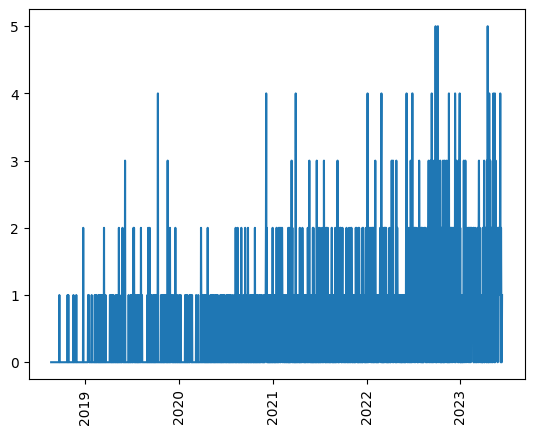

In [35]:
plt.plot(
    new_df.loc[new_df['product_id'] == 20552]['date'],
    new_df.loc[new_df['product_id'] == 20552]['sales_count'],
)
plt.xticks(rotation='vertical')

(array([17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

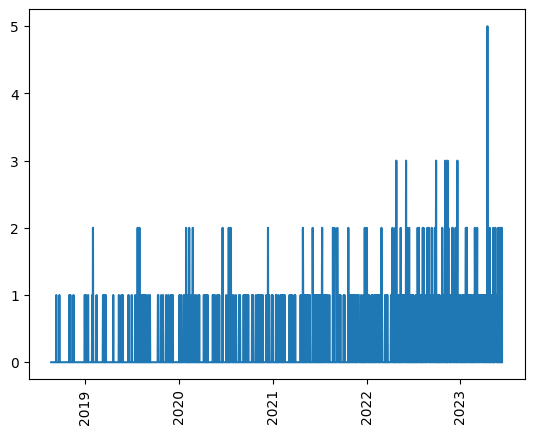

In [36]:
plt.plot(
    new_df.loc[new_df['product_id'] == 20547]['date'],
    new_df.loc[new_df['product_id'] == 20547]['sales_count'],
)
plt.xticks(rotation='vertical')

(array([17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

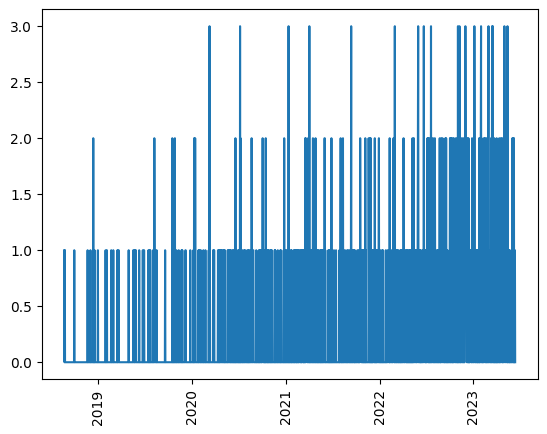

In [37]:
plt.plot(
    new_df.loc[new_df['product_id'] == 28305]['date'],
    new_df.loc[new_df['product_id'] == 28305]['sales_count'],
)
plt.xticks(rotation='vertical')

(array([17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

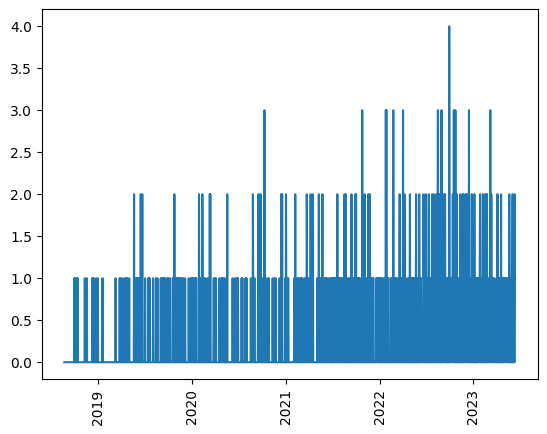

In [38]:
plt.plot(
    new_df.loc[new_df['product_id'] == 23641]['date'],
    new_df.loc[new_df['product_id'] == 23641]['sales_count'],
)
plt.xticks(rotation='vertical')

(array([17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

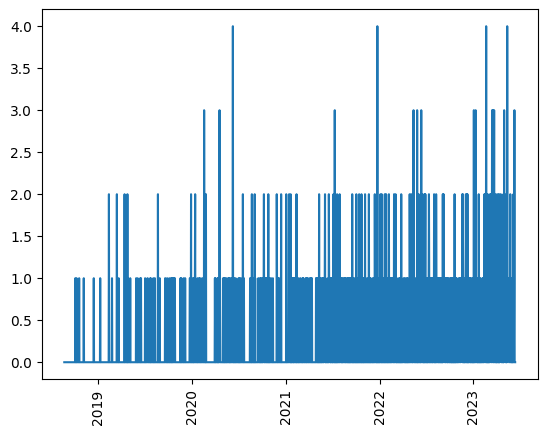

In [39]:
plt.plot(
    new_df.loc[new_df['product_id'] == 13596]['date'],
    new_df.loc[new_df['product_id'] == 13596]['sales_count'],
)
plt.xticks(rotation='vertical')

**List the data types for the `new_df` dataframe.**

In [40]:
new_df.dtypes

date           datetime64[ns]
product_id              int64
sales_count             int64
dtype: object

**Create a new BigQuery table out of the `new_df` dataframe.**

In [41]:
job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[
        bigquery.SchemaField('product_id', bigquery.enums.SqlTypeNames.INTEGER),
        bigquery.SchemaField('date', bigquery.enums.SqlTypeNames.DATE),
        bigquery.SchemaField('sales_count', bigquery.enums.SqlTypeNames.INTEGER),
    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition='WRITE_TRUNCATE',
)

# save the dataframe to a table in the created dataset
job = bq_client.load_table_from_dataframe(
    new_df,
    f'{PROJECT_ID}.{dataset_id}.{SALES_TABLE}',
    job_config=job_config,
)  # Make an API request.
job.result()  # Wait for the job to complete.

LoadJob<project=automlops-sandbox, location=US, id=1a57939e-d30a-43b2-afe9-5681a9d7c7f9>

**Create a training dataset by setting a date range that limits the data being used.**

In [42]:
# select the date-range and item-id(top 5) for training-data and create a table for the same
TRAININGDATA_STARTDATE = '2022-01-01'
TRAININGDATA_ENDDATE = '2023-01-01'
query = f'''
CREATE OR REPLACE TABLE {PROJECT_ID}.{dataset_id}.training_data AS (
    SELECT
        *
    FROM
        `{dataset_id}.{SALES_TABLE}`
    WHERE
        date BETWEEN '{TRAININGDATA_STARTDATE}' AND '{TRAININGDATA_ENDDATE}'
        );
'''
# execute the query (as it is a create query, there won't be any tabular output)
query_job = bq_client.query(query)
print(query_job.result())

**Select the original data for plotting.**

In [43]:
df_historical = new_df[
    (new_df['date'] >= pd.to_datetime(TRAININGDATA_STARTDATE))
    & (new_df['date'] <= pd.to_datetime(TRAININGDATA_ENDDATE))
].copy()
df_historical

,date,product_id,sales_count
1229,2022-01-01,20552,1
1230,2022-01-02,20552,1
1231,2022-01-03,20552,0
1232,2022-01-04,20552,1
1233,2022-01-05,20552,4
...,...,...,...
8622,2022-12-28,20547,1
8623,2022-12-29,20547,0
8624,2022-12-30,20547,0
8625,2022-12-31,20547,0


## Modeling with BigQuery and the ARIMA model

**Create an ARIMA model using the training data.**

In [44]:
# Train an ARIMA model on the created dataset
query = f'''
CREATE OR REPLACE MODEL `{PROJECT_ID}.{dataset_id}.arima_model`

OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='date',
  TIME_SERIES_DATA_COL='sales_count',
  TIME_SERIES_ID_COL='product_id',
  SEASONALITIES=['DAILY','WEEKLY','MONTHLY','QUARTERLY','YEARLY'],
  DATA_FREQUENCY='DAILY',
  model_registry='vertex_ai') AS

SELECT
    date,
    product_id,
    sales_count
FROM
  `{dataset_id}.training_data`
'''
job = bq_client.query(query)
job.result()

## Evaluate the model

To evaluate the trained model, get forecasts for the 90 days after the last date of the training data. In BigQuery ML, provide the number of forecast days using the `HORIZON` argument. Specify the confidence interval for the forecast using the `CONFIDENCE_LEVEL` argument.

**Load the data into a dataframe named `dfforecast`.**

In [45]:
query = f'''DECLARE HORIZON STRING DEFAULT "90"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90"; ## required confidence level

EXECUTE IMMEDIATE format("""
    SELECT
      * , 
      ROUND(forecast_value) AS forecast_value_rnd,
      ROUND(forecast_value) - standard_error AS prediction_interval_lower_bound_rnd,
      ROUND(forecast_value) - standard_error AS confidence_interval_lower_bound_rnd,
      ROUND(forecast_value) + standard_error AS prediction_interval_upper_bound_rnd,
      ROUND(forecast_value) + standard_error AS confidence_interval_upper_bound_rnd
    FROM
      ML.FORECAST(MODEL {dataset_id}.arima_model,
                  STRUCT(%s AS horizon,
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)'''
job = bq_client.query(query)
dfforecast = job.to_dataframe()

**View the first few rows.**

In [46]:
dfforecast.head()

,product_id,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound,forecast_value_rnd,prediction_interval_lower_bound_rnd,confidence_interval_lower_bound_rnd,prediction_interval_upper_bound_rnd,confidence_interval_upper_bound_rnd
0,13596,2023-01-02 00:00:00+00:00,-0.166704,0.000149,0.9,-0.166949,-0.166460,-0.166949,-0.166460,-0.0,-0.000149,-0.000149,0.000149,0.000149
1,13596,2023-01-03 00:00:00+00:00,0.036944,0.000332,0.9,0.036398,0.037491,0.036398,0.037491,0.0,-0.000332,-0.000332,0.000332,0.000332
2,13596,2023-01-04 00:00:00+00:00,0.403935,0.000556,0.9,0.403020,0.404849,0.403020,0.404849,0.0,-0.000556,-0.000556,0.000556,0.000556
3,13596,2023-01-05 00:00:00+00:00,0.307543,0.000814,0.9,0.306205,0.308881,0.306205,0.308881,0.0,-0.000814,-0.000814,0.000814,0.000814
4,13596,2023-01-06 00:00:00+00:00,0.989961,0.001103,0.9,0.988149,0.991773,0.988149,0.991773,1.0,0.998897,0.998897,1.001103,1.001103


In [47]:
print(f'Number of rows: {dfforecast.shape[0]}')

Number of rows: 450


**Clean the historical and forecasted values for plotting.**

In [48]:
df_historical.sort_values(by=['product_id', 'date'], inplace=True)
dfforecast.sort_values(by=['product_id', 'forecast_timestamp'], inplace=True)

# Select the actual data to plot against the forecasted data
day_diff = (new_df['date'] - pd.to_datetime(TRAININGDATA_ENDDATE)).dt.days
df_actual_90d = new_df[new_df['product_id'].isin(dfforecast['product_id'].unique())][
    (day_diff > 0) & (day_diff <= 90)
].copy()
df_actual_90d.shape

(450, 3)

**Plot the historical and forecast data.**


Product_id :  13596


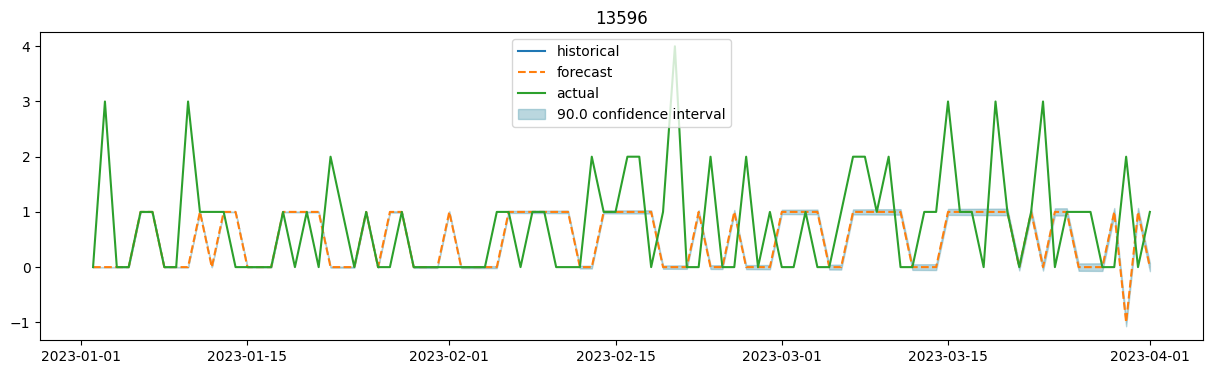

Product_id :  20547


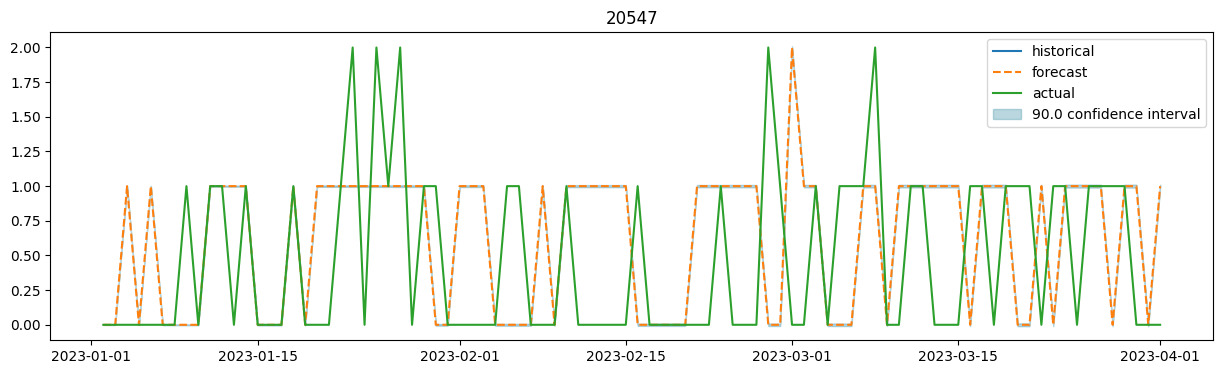

Product_id :  20552


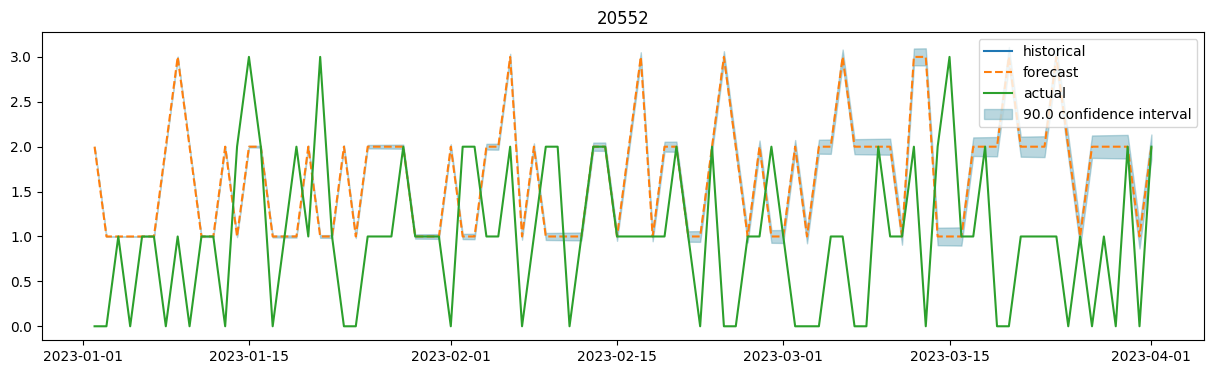

Product_id :  23641


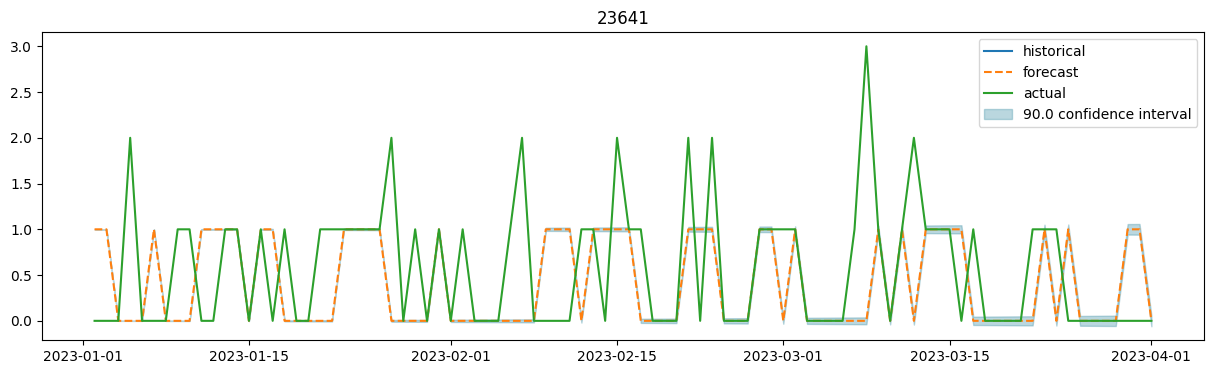

Product_id :  28305


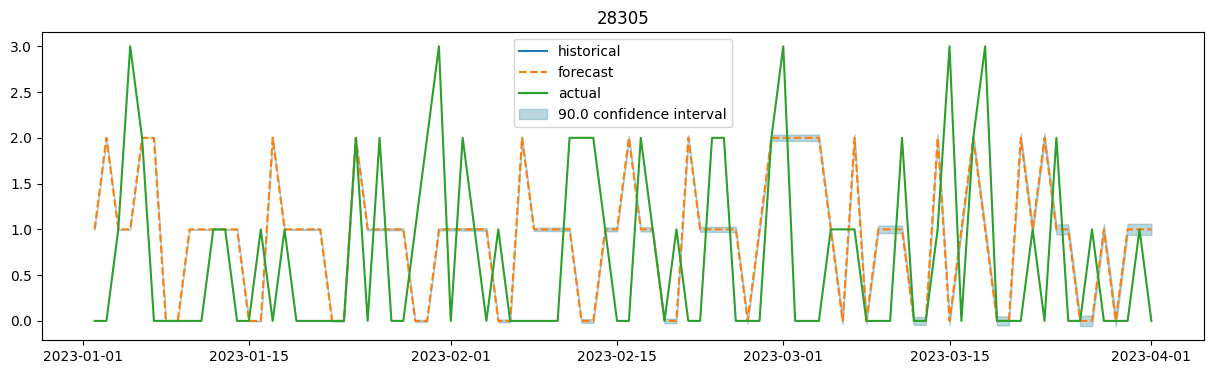

In [49]:
def plot_hist_forecast(
    historical, forecast, actual, hist_start='', hist_end='', title=''
):
    if hist_start != '':
        historical = historical[
            historical['date'] >= pd.to_datetime(hist_start, format='%Y-%m-%d')
        ].copy()
    if hist_end != '':
        historical = historical[
            historical['date'] <= pd.to_datetime(hist_end, format='%Y-%m-%d')
        ].copy()

    plt.figure(figsize=(15, 4))
    plt.plot(historical['date'], historical['sales_count'], label='historical')
    # Plot the forecast data
    plt.plot(
        forecast['forecast_timestamp'],
        forecast['forecast_value_rnd'],
        label='forecast',
        linestyle='--',
    )
    # Plot the actual data
    plt.plot(actual['date'], actual['sales_count'], label='actual')
    # plot the confidence interval
    confidence_level = forecast['confidence_level'].iloc[0] * 100
    low_CI = forecast['confidence_interval_lower_bound_rnd']
    upper_CI = forecast['confidence_interval_upper_bound_rnd']

    # Shade the confidence interval
    plt.fill_between(
        forecast['forecast_timestamp'],
        low_CI,
        upper_CI,
        color='#539caf',
        alpha=0.4,
        label=f'{confidence_level} confidence interval',
    )
    plt.legend()
    plt.title(title)
    plt.show()
    return


product_id_list = dfforecast['product_id'].unique()
for i in product_id_list:
    print('Product_id : ', i)
    plot_hist_forecast(
        df_historical[df_historical['product_id'] == i],
        dfforecast[dfforecast['product_id'] == i],
        df_actual_90d[df_actual_90d['product_id'] == i],
        hist_start='2023-02-01',
        title=i,
    )

While most of the predictions are looking decent, you can also see that the actual ranges fall into the 90% confidence interval suggested by the model. Under the hood, BigQuery ML performs many computationally expensive tasks even considering the seasonal and holiday information.
<img src="https://cloud.google.com/bigquery-ml/images/BQ_ARIMA_diagram.png"> <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series"> Source</a> </img>

The coefficients learned by BigQuery ML's ARIMA model can also be checked by querying for <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients">ARIMA_COEFFICIENTS</a> from the model.

In [50]:
query = f'''
SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL {dataset_id}.arima_model)
'''
query_job = bq_client.query(query)

In [51]:
query_job.to_dataframe()

,product_id,ar_coefficients,ma_coefficients,intercept_or_drift
0,13596,[],[],0.000000
1,20547,[],[],0.000653
2,20552,[],[0.1090983535507289],0.000000
3,23641,[],[],0.000000
4,28305,[],[],0.000000


In the above results, 
- The <b>product_id</b> column represents the index column that we've specified while training the ARIMA model.
- The <b>ar_coefficients</b> column corresponds to the autoregressive coefficients in the ARIMA algorithm (non-seasonal p).
- <b>ma_coefficients</b> refers to the moving average coefficients in the ARIMA algorithm (non-seasonal q).
- <b>intercept_or_drift</b> is the constant term in the ARIMA algorithm.

## Evaluating the model results using BigQuery ML 

BigQuery ML also provides the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate">ML.EVALUATE</a> function for checking the evaluation metrics of the trained model. For the ARIMA model, you can see the model being evaluated on `log_likelihood`, `AIC` and `variance`. 

In [52]:
query = f'''
SELECT
  *
FROM
  ML.EVALUATE(MODEL {dataset_id}.arima_model)
'''
query_job = bq_client.query(query)

In [53]:
query_job.to_dataframe()

,product_id,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes
0,13596,0,2,0,False,2691.656780,-5381.313560,2.211079e-08,"[WEEKLY, MONTHLY, QUARTERLY]",False,True,False
1,20547,0,1,0,True,1958.712420,-3913.424841,1.277574e-06,"[WEEKLY, MONTHLY, QUARTERLY]",False,True,True
2,20552,0,2,1,False,2507.187216,-5010.374432,6.092246e-08,"[WEEKLY, MONTHLY, QUARTERLY]",False,True,False
3,23641,0,2,0,False,2771.032261,-5540.064522,1.429539e-08,"[WEEKLY, MONTHLY, QUARTERLY]",False,True,False
4,28305,0,2,0,False,2757.135374,-5512.270749,1.542969e-08,"[WEEKLY, MONTHLY, QUARTERLY]",False,True,False


## Evaluating the model results - MAE, MAPE, MSE, RMSE (on Test data)

Generally, to evaluate the forecast model, you can choose metrics depending on how you want to evaluate. For starters, you can choose from the following:

- **Mean Absolute Error (MAE)**: Average of the absolute differences between the actual values and the forecasted values.
- **Mean Absolute Percentage Error (MAPE)**: Average of the percentages of absolute difference between the actual and forecasted values to the actual values.
- **Mean Squared Error (MSE)**: Average of squared differences between the actual and forecasted values.
- **Root Mean Squared Error (RMSE)**: Root of MSE

In [54]:
df_actual_90d.sort_values(by=['product_id', 'date'], inplace=True)
df_actual_90d.reset_index(drop=True, inplace=True)
dfforecast.sort_values(by=['product_id', 'forecast_timestamp'], inplace=True)
dfforecast.reset_index(drop=True, inplace=True)

In [61]:
errors = {'product_id': [], 'MAE': [], 'MAPE': [], 'MSE': [], 'RMSE': []}
for i in product_id_list:
    mae = mean_absolute_error(
        df_actual_90d[df_actual_90d['product_id'] == i]['sales_count'],
        dfforecast[dfforecast['product_id'] == i]['forecast_value_rnd'],
    )
    mape = mean_absolute_percentage_error(
        df_actual_90d[df_actual_90d['product_id'] == i]['sales_count'],
        dfforecast[dfforecast['product_id'] == i]['forecast_value_rnd'],
    )

    mse = mean_squared_error(
        df_actual_90d[df_actual_90d['product_id'] == i]['sales_count'],
        dfforecast[dfforecast['product_id'] == i]['forecast_value_rnd'],
        squared=True,
    )

    rmse = mean_squared_error(
        df_actual_90d[df_actual_90d['product_id'] == i]['sales_count'],
        dfforecast[dfforecast['product_id'] == i]['forecast_value_rnd'],
        squared=False,
    )

    errors['product_id'].append(i)
    errors['MAE'].append(mae)
    errors['MAPE'].append(mape)
    errors['MSE'].append(mse)
    errors['RMSE'].append(rmse)
errors = pd.DataFrame(errors)
errors

,product_id,MAE,MAPE,MSE,RMSE
0,13596,0.700000,9.507599e+14,1.233333,1.110555
1,20547,0.577778,1.651320e+15,0.622222,0.788811
2,20552,0.977778,2.401920e+15,1.644444,1.282359
3,23641,0.488889,7.505999e+14,0.644444,0.802773
4,28305,0.888889,2.401920e+15,1.333333,1.154701


# Part 2 : Automating pipeline creation with AutoMLOps<a id='automlops'></a>

## Import AutoMLOps

In [62]:
from google_cloud_automlops import AutoMLOps

## Other Imports

In [ ]:
!pip3 install kfp<2.0.0

In [63]:
from kfp.v2 import dsl
from kfp.v2.dsl import Artifact, Dataset, Metrics, Output

## Clear the cache
`AutoMLOps.clear_cache` will remove previous instantiations of AutoMLOps components and pipelines. Use this function if you have previously defined a component that you no longer need.

In [64]:
AutoMLOps.clear_cache()

Cache cleared.


## Define an AutoMLOps component for Preparing Sales Table

In [65]:
@AutoMLOps.component
def prepare_sales_table(
    dataset_id: str,
    project_id: str,
    sales_table: str
):
    """Custom component that prepares the sales table.

    Args:
        dataset_id: Destination BigQuery dataset.
        project_id: The project ID.
        sales_table: Source BigQuery table.
    """
    import datetime
    
    import pandas as pd
    from google.cloud import bigquery
    bq_client = bigquery.Client(project=project_id)

    def merge_dataframes(base_df, dates_df, product_id):
        ''' Zero-fill dates with no product purchases'''
        dataframe = (
            pd.merge(
                base_df.loc[base_df['product_id'] == product_id],
                dates_df,
                left_on='date',
                right_on=0,
                how='outer',
            )
            .sort_values(by=['date'])
            .drop(columns=0)
        )  # merging dates dataframe with product_id matching rows
        dataframe['product_id'] = product_id  # product_id will be null so making it the specified values
        dataframe.reset_index(inplace=True, drop=True)  # making index to start from 0
        dataframe = dataframe.fillna(0)  # for sales_count making null values as 0
        dataframe['sales_count'] = dataframe['sales_count'].astype(
            'int'
        )
        return dataframe

    query = f'''
    SELECT * FROM {dataset_id}.top_five_products
    '''
    query_job = bq_client.query(query)
    df = query_job.to_dataframe()
    
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    end_time = datetime.datetime.now().strftime('%Y-%m-%d')
    start_time = '2018-08-14' # min date
    dates = pd.date_range(start=start_time, end=end_time).to_frame()
    
    product_dataframes = []
    for product_id in df['product_id'].unique():
        product_dataframes.append(merge_dataframes(df, dates, product_id))
    
    full_df = pd.concat(product_dataframes)
    full_df.reset_index(inplace=True, drop=True)

    job_config = bigquery.LoadJobConfig(
        schema=[
            bigquery.SchemaField('product_id', bigquery.enums.SqlTypeNames.INTEGER),
            bigquery.SchemaField('date', bigquery.enums.SqlTypeNames.DATE),
            bigquery.SchemaField('sales_count', bigquery.enums.SqlTypeNames.INTEGER),
        ],
        write_disposition='WRITE_TRUNCATE'
    )
    # save the dataframe to a table in the created dataset
    job = bq_client.load_table_from_dataframe(
        full_df,
        f'{project_id}.{dataset_id}.{sales_table}',
        job_config=job_config)
    job.result()

## Define an AutoMLOps component for Creating Training Data

In [66]:
@AutoMLOps.component
def create_training_dataset(
    dataset_id: str,
    project_id: str,
    sales_table: str,
    year_range: int
):
    """Custom component that creates training data, ranging from today to N year(s) ago.

    Args:
        dataset_id: Destination BigQuery dataset.
        project_id: The project ID.
        sales_table: Source BigQuery table.
        year_range: Number of years to train the model on.
    """
    from google.cloud import bigquery
    bq_client = bigquery.Client(project=project_id)

    query = f'''
    CREATE OR REPLACE TABLE {project_id}.{dataset_id}.training_data AS (
        SELECT
            *
        FROM
            `{dataset_id}.{sales_table}`
        WHERE
            date BETWEEN DATE_ADD(CURRENT_DATE(), INTERVAL -{year_range} YEAR) AND CURRENT_DATE()
            );
    '''
    query_job = bq_client.query(query)
    print(query_job.result())

## Define an AutoMLOps component for Model Training

In [67]:
@AutoMLOps.component
def train_model(
    dataset_id: str,
    model_name: str,
    model_type: str,
    project_id: str
):
    """Train an ARIMA model on the training dataset.

    Args:
        dataset_id: Destination BigQuery dataset.
        model_name: Name for the model.
        model_type: The column which are the labels.
        project_id: The project ID.
    """
    from google.cloud import bigquery
    bq_client = bigquery.Client(project=project_id)

    query = f'''
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.{model_name}`

    OPTIONS(
      MODEL_TYPE='{model_type}',
      TIME_SERIES_TIMESTAMP_COL='date',
      TIME_SERIES_DATA_COL='sales_count',
      TIME_SERIES_ID_COL='product_id',
      SEASONALITIES=['DAILY','WEEKLY','MONTHLY','QUARTERLY','YEARLY'],
      DATA_FREQUENCY='DAILY',
      model_registry='vertex_ai') AS

    SELECT
        date,
        product_id,
        sales_count
    FROM
      `{dataset_id}.training_data`
    '''
    query_job = bq_client.query(query)
    print(query_job.result())

## Define a Component for Model Evaluation

In [68]:
@dsl.component(
    packages_to_install=[
        'google-cloud-bigquery', 
        'pandas',
        'pyarrow',
        'db_dtypes'
    ],
    output_component_file=f'{AutoMLOps.OUTPUT_DIR}/evaluate_model.yaml')
def evaluate_model(
    dataset_id: str,
    metrics: Output[Metrics],
    model_name: str,
    project_id: str
):
    """Evaluate the trained ARIMA model.

    Args:
        dataset_id: Destination BigQuery dataset.
        model_name: Name for the model.
        project_id: The project ID.
    """
    from google.cloud import bigquery
    bq_client = bigquery.Client(project=project_id)

    query = f'''
    SELECT
      *
    FROM
      ML.EVALUATE(MODEL {dataset_id}.{model_name})
    '''
    query_job = bq_client.query(query)
    results = query_job.result().to_dataframe()

    for _, row in results.iterrows():
        for m in ['log_likelihood', 'AIC', 'variance']:
            metrics.log_metric(f'''Product id: {row['product_id']} | Metric: {m}''', row[m])

## Define a Component for Forecasting

In [69]:
@dsl.component(
    packages_to_install=[
        'google-cloud-bigquery'
    ],
    output_component_file=f'{AutoMLOps.OUTPUT_DIR}/forecast.yaml')
def forecast(
    bq_forecast_table: Output[Dataset],
    confidence_lvl: float,
    dashboard: Output[Artifact],
    dataset_id: str,
    forecast_horizon: int,
    project_id: str
):
    """Custom component that runs a forecast for a given horizon period.

    Args:
        bq_forecast_table: Full uri of the BQ table forecast results.
        confidence_lvl: Required confidence level.
        dashboard: URL of the Looker dashboard.
        dataset_id: Destination BigQuery dataset.
        forecast_horizon: Number of days forward to forecast.
        project_id: The project ID.
    """
    from google.cloud import bigquery
    bq_client = bigquery.Client(project=project_id)

    query = f'''DECLARE HORIZON STRING DEFAULT "{forecast_horizon}";
    DECLARE CONFIDENCE_LEVEL STRING DEFAULT "{confidence_lvl}";

    EXECUTE IMMEDIATE format("""
        CREATE OR REPLACE VIEW {dataset_id}.arima_forecast AS (
        SELECT
          * , 
          ROUND(forecast_value) AS forecast_value_rnd,
          ROUND(forecast_value) - standard_error AS prediction_interval_lower_bound_rnd,
          ROUND(forecast_value) - standard_error AS confidence_interval_lower_bound_rnd,
          ROUND(forecast_value) + standard_error AS prediction_interval_upper_bound_rnd,
          ROUND(forecast_value) + standard_error AS confidence_interval_upper_bound_rnd
        FROM
          ML.FORECAST(MODEL {dataset_id}.arima_model,
                      STRUCT(%s AS horizon,
                             %s AS confidence_level)
                     )
        )
        """,HORIZON,CONFIDENCE_LEVEL)'''
    job = bq_client.query(query)
    bq_forecast_table.uri = f'bq://{project_id}.{dataset_id}.arima_forecast'
    dashboard.uri = 'https://lookerstudio.google.com/reporting/526d02a9-37f5-404a-87a4-148343e1cc49'

## Define an AutoMLOps pipeline

In [70]:
@AutoMLOps.pipeline(
    name='bqml-automlops-retail-forecasting',
    description='This is an example of retail demand forecasting using AutoMLOps and BQML.')
def pipeline(confidence_lvl: float,
             dataset_id: str,
             forecast_horizon: int,
             machine_type: str,
             model_name: str,
             model_type: str,
             project_id: str,
             sales_table: str,
             year_range: int):
    
    prepare_sales_table_task = prepare_sales_table(
        dataset_id=dataset_id,
        project_id=project_id,
        sales_table=sales_table)        

    create_training_dataset_task = create_training_dataset(
        dataset_id=dataset_id,
        project_id=project_id,
        sales_table=sales_table,
        year_range=year_range).after(prepare_sales_table_task)

    train_model_task = train_model(
        dataset_id=dataset_id,
        model_name=model_name,
        model_type=model_type,
        project_id=project_id).after(create_training_dataset_task)

    evaluate_model_task = evaluate_model(
        dataset_id=dataset_id,
        model_name=model_name,
        project_id=project_id).after(train_model_task)
    
    forecast_task = forecast(
        confidence_lvl=confidence_lvl,
        dataset_id=dataset_id,
        forecast_horizon=forecast_horizon,
        project_id=project_id).after(evaluate_model_task)

## Define the Pipeline Arguments

In [71]:
pipeline_params = {
    'confidence_lvl': 0.90,
    'dataset_id': dataset_id,
    'forecast_horizon': 90,
    'machine_type': 'n1-standard-4',
    'model_name': 'arima_model',
    'model_type': 'ARIMA_PLUS',
    'project_id': PROJECT_ID,
    'sales_table': SALES_TABLE,
    'year_range': 1
}

## Generate and Run the pipeline
`AutoMLOps.generate(...)` generates the MLOps codebase. Users can specify the tooling and technologies they would like to use in their MLOps pipeline.

In [ ]:
AutoMLOps.generate(project_id=PROJECT_ID,
                   pipeline_params=pipeline_params,
                   use_ci=True,
                   naming_prefix=MODEL_ID,
                   schedule_pattern='59 11 * * 0' # retrain every Sunday at Midnight
)

Writing directories under AutoMLOps/
Writing configurations to AutoMLOps/configs/defaults.yaml
Writing Kubeflow Pipelines code to AutoMLOps/pipelines, AutoMLOps/components, AutoMLOps/services
Writing README.md to AutoMLOps/README.md
Writing scripts to AutoMLOps/scripts
Writing CloudBuild config to AutoMLOps/cloudbuild.yaml
Code Generation Complete.


`AutoMLOps.provision(...)` runs provisioning scripts to create and maintain necessary infra for MLOps.

In [ ]:
AutoMLOps.provision(hide_warnings=False)            # hide_warnings is optional, defaults to True

-cloudfunctions.functions.get
-serviceusage.services.use
-serviceusage.services.enable
-cloudfunctions.functions.create
-pubsub.subscriptions.list
-cloudscheduler.jobs.list
-pubsub.topics.create
-source.repos.list
-artifactregistry.repositories.create
-resourcemanager.projects.setIamPolicy
-iam.serviceAccounts.listiam.serviceAccounts.create
-pubsub.subscriptions.create
-cloudscheduler.jobs.create
-storage.buckets.create
-source.repos.create
-artifactregistry.repositories.list
-cloudbuild.builds.create
-cloudbuild.builds.list
-pubsub.topics.list
-storage.buckets.get

You are currently using: srastatter@google.com. Please check your account permissions.
The following are the recommended roles for provisioning:
-roles/resourcemanager.projectIamAdmin
-roles/cloudfunctions.admin
-roles/artifactregistry.admin
-roles/iam.serviceAccountAdmin
-roles/serviceusage.serviceUsageAdmin
-roles/aiplatform.serviceAgent
-roles/cloudscheduler.admin
-roles/pubsub.editor
-roles/source.admin
-roles/cloudbuil

`AutoMLOps.deploy(...)` builds and pushes component container, then triggers the pipeline job.

In [ ]:
AutoMLOps.deploy(precheck=True,                     # precheck is optional, defaults to True
                 hide_warnings=False)               # hide_warnings is optional, defaults to True

-artifactregistry.repositories.get
-cloudbuild.builds.get
-resourcemanager.projects.getIamPolicy
-storage.buckets.update
-serviceusage.services.get
-cloudfunctions.functions.get
-pubsub.topics.get
-iam.serviceAccounts.get
-source.repos.update
-pubsub.subscriptions.get

You are currently using: srastatter@google.com. Please check your account permissions.
The following are the recommended roles for deploying with precheck:
-roles/serviceusage.serviceUsageViewer
-roles/iam.roleViewer
-roles/pubsub.viewer
-roles/storage.admin
-roles/cloudbuild.builds.editor
-roles/source.writer
-roles/iam.serviceAccountUser
-roles/cloudfunctions.viewer
-roles/artifactregistry.reader

Checking for required API services in project automlops-sandbox...
Checking for Artifact Registry in project automlops-sandbox...
Checking for Storage Bucket in project automlops-sandbox...
Checking for Pipeline Runner Service Account in project automlops-sandbox...
Checking for IAM roles on Pipeline Runner Service Account in